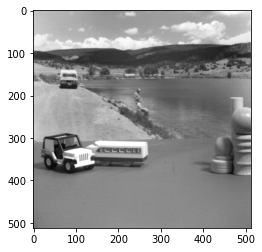

In [1]:
import os

import cv2
import matplotlib.pyplot as plt

import numpy as np
import random

random.seed(10)
%matplotlib inline
path_to_images = os.getcwd() + "/images/grey/"
test_image = np.float32(np.asarray(cv2.imread(path_to_images + "motion06.512.tiff", cv2.IMREAD_GRAYSCALE)))
plt.imshow(test_image, cmap='gray')

In [2]:
def cut_image_into_blocks(im, n=8):
    for s in im.shape:
        if s % n != 0:
            raise RuntimeError('Shapes do not match: {} % {} != 0'.format(s, n)) from exc
    
    rows = im.shape[0] // n
    res = [[] for _ in range(rows)]
    
    for i in range(rows):
        row_ind = i*n
        for j in range(rows):
            col_ind = j*n
            res[i].append(im[row_ind:row_ind+n, col_ind:col_ind+n])
            
    return np.asarray(res)

def concatenate_image(im):
    res = []
    for r in im:
        res.append(np.concatenate(r, axis=1))
        
    return np.asarray(np.concatenate(res, axis=0))

splitted_image = cut_image_into_blocks(test_image)

In [3]:
qm = np.array( [[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]) 

def count_v_i(block, n=8):
    v = 0
    
    for i in range(2, n*n+1):
        row = (i-1)// n
        col = (i-1) % n
        if block[row][col] != 0:
            v += 1
    
    return v

def g_j(j):
    if j <= 7:
        return 0
    elif j<= 31:
        return 1
    elif j <= 41:
        return 2
    else:
        return 3

def count_w_i(block, n=8):
    w = 0
    
    for i in range(2, n*n+1):
        row = (i-1)// n
        col = (i-1) % n
        if block[row][col] != 0:
            w += g_j(i)
    
    return w

def dct2d(a):
    return cv2.dct(a)

def idct2d(a):
    return np.around(cv2.idct(a))

def get_dct_coefs(im):
    dct_blocks = [[] for row in im]

    for i in range(len(im)):
        for block in im[i]:
            dct_blocks[i].append(dct2d(block))
    
    return np.asarray(dct_blocks)

def get_image_from_dct_coefs(im):
    idct_blocks = [[] for row in im]

    for i in range(len(im)):
        for block in im[i]:
            idct_blocks[i].append(idct2d(block))
    
    return np.asarray(idct_blocks)

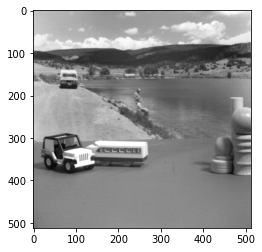

In [4]:
blocks = [[] for row in splitted_image]

for i in range(len(splitted_image)):
    for block in splitted_image[i]:
        blocks[i].append(idct2d(dct2d(block)))

restructed_image = (concatenate_image(blocks))
plt.imshow(restructed_image, cmap='gray')

In [5]:
from numpy.random import randint

message = randint(0, 2, size=153843)

In [6]:
from math import floor

def insert_message_PM1(image, message):
    L = len(message)
    
    #step1
    blocks = cut_image_into_blocks(image)
    dct_blocks = get_dct_coefs(blocks)
    
    #step2
    V = []
    W = []
    for row in dct_blocks:
        for block in row:
            V.append(count_v_i(block))
            W.append(count_w_i(block))

    #step3
    K = len(V)
    S = [i for i in range(K)]
    

    #step4
    flag = True
    while flag:
        flag = False
        for p in range(0, K-1):
            for q in range(p+1, K):
                if not(V[S[p]] > V[S[q]] or (V[S[p]] == V[S[q]] and W[S[p]] >= W[S[q]])):
                    S[p], S[q] = S[q], S[p]
                    flag = True

    #step5
    U = [[0 for i in range(L)] for _ in range(2)]
    n = 0
    f = 63
    y = 0
    
    #step6
    while y < L and f >= 0:
        row_c = f // 8
        col_c = f % 8
        
        row_b = S[n] // 64
        col_b = S[n] % 64
        
        c = dct_blocks[row_b][col_b][row_c][col_c]
        
        if floor(c) != 0:
            U[0][y] = S[n]
            U[1][y] = f
            y += 1
        
        n += 1
        if n >= K:
            n = 1
            f -= 1
    
    if f < 0:
        raise RuntimeError("Can embed only {} bits, ran out of non-zero DCT coefficients".format(y))

    #step7
    y = 0

    #step8
    while y < L:
        row_b = U[0][y] // 64
        col_b = U[0][y] % 64

        row_c = U[1][y] // 8
        col_c = U[1][y] % 8

        c_orig = dct_blocks[row_b][col_b][row_c][col_c]
        c = floor(c_orig)
        #step8.1
        if message[y] == 0:
            #step8.3
            if (c < 0 and c % 2 == 1) or (c > 0 and c % 2 == 0):
                y += 1
                continue
        else:
            #step8.2
            if (c < 0 and c % 2 == 0) or (c > 0 and c % 2 == 1):
                y += 1
                continue

        #step8.4
        r = 0

        if abs(c) > 1:
            r = randint(0, 2)
        #step8.5
        elif c == 1:
            r = 0
        else:
            r = 1

        #step8.6
        if r == 1:
            dct_blocks[row_b][col_b][row_c][col_c] = c_orig - 1
        else:
            dct_blocks[row_b][col_b][row_c][col_c] = c_orig + 1

        y += 1

    new_image = get_image_from_dct_coefs(dct_blocks)
    return U, concatenate_image(new_image)


U, embedded_image = insert_message_PM1(test_image, message)

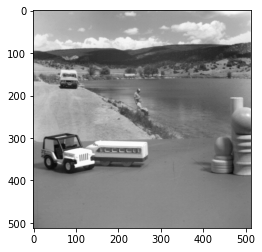

In [7]:
plt.imshow(embedded_image, cmap='gray')

In [8]:
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

print(PSNR(test_image, embedded_image))

52.45668661482593


In [9]:
def extract_message(im, route):
    dct_blocks = get_dct_coefs(cut_image_into_blocks(im))
    mes = []
    
    for i in range(len(route[0])):
        b = route[0][i]
        
        row_b = b // 64
        col_b = b % 64
        
        c = route[1][i]
        
        row_c = c // 8
        col_c = c % 8
        
        c = floor(dct_blocks[row_b][col_b][row_c][col_c])
        
        if (c < 0 and c % 2 == 1) or (c > 0 and c % 2 == 0):
            mes.append(0)
        else:
            mes.append(1)
    
    return mes

In [10]:
new_message = extract_message(embedded_image, U)

In [11]:
from skimage.metrics import structural_similarity as ssim

def count_BER(a, b):
    ber = 0
    for x, y in zip(a, b):
        if x != y:
            ber += 1
    
    return ber / len(a)

In [12]:
count_BER(new_message, message)

0.22100453059287714

Все что было до этого - это реализация алгоритмов и проверка их работы, сам эксперимент производится далее

In [13]:
from os import listdir
from os.path import isfile, join

mypath = os.getcwd() + "/images/grey/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('.DS_Store')
onlyfiles

['5.2.08.tiff',
 '7.1.10.tiff',
 '1.1.06.tiff',
 'boat.512.tiff',
 '5.2.09.tiff',
 '7.1.07.tiff',
 '1.2.11.tiff',
 'motion06.512.tiff',
 '7.1.01.tiff',
 '1.1.03.tiff',
 '7.1.02.tiff',
 '7.1.03.tiff',
 '1.2.04.tiff',
 '7.1.04.tiff',
 '5.2.10.tiff',
 '7.1.08.tiff',
 '1.1.12.tiff',
 '1.2.02.tiff',
 '7.1.09.tiff',
 '7.1.05.tiff']

In [14]:
import time

def get_metrics(im, mes):
    U, emb = insert_message_PM1(im, mes)
    res = extract_message(emb, U)
    
    ssim_noise = ssim(im, emb, data_range=emb.max() - emb.min())
    ber = count_BER(mes, res)
    psnr = PSNR(im, emb)
    
    return psnr, ssim_noise, ber

def make_experiment(files):
    MAX_VALUE = 153843
    PERCENTAGES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    PSNR_VALUES = []
    SSIM_VALUES = []
    BER_VALUES = []
    TIME_VALUES = []
    
    for p in PERCENTAGES:
        m_len = round(p * MAX_VALUE)
        m = randint(0, 2, size=int(m_len))
        
        print(len(m))
        
        p = []
        s = []
        b = []
        t = []
        for f in files:
            path_to_images = os.getcwd() + "/images/grey/"
            
            start = time.time()
            test_image = np.float32(np.asarray(cv2.imread(path_to_images + f, cv2.IMREAD_GRAYSCALE)))
            psnr, ssim_noise, ber = get_metrics(test_image, m)
            end = time.time()
            
            t.append(end-start)
            p.append(psnr)
            s.append(ssim_noise)
            b.append(ber)
        
        PSNR_VALUES.append(np.mean(p))
        SSIM_VALUES.append(np.mean(s))
        BER_VALUES.append(np.mean(b))
        TIME_VALUES.append(np.mean(t))
    
    return PSNR_VALUES, SSIM_VALUES, BER_VALUES, TIME_VALUES

In [15]:
p_v, s_v, b_v, t_v = make_experiment(onlyfiles[])

15384
30769
46153
61537
76922
92306
107690
123074
138459
153843


In [34]:
def custom_plot(x, y, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, **plt_kwargs) ## example plot here
    return(ax)

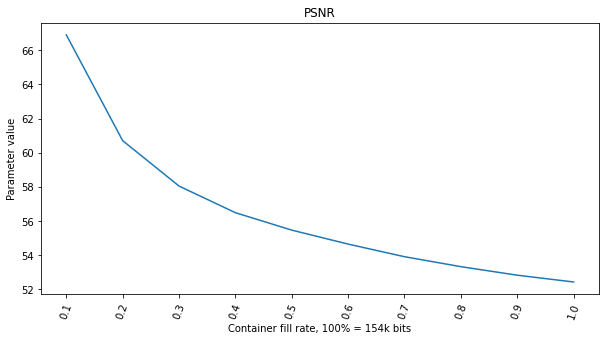

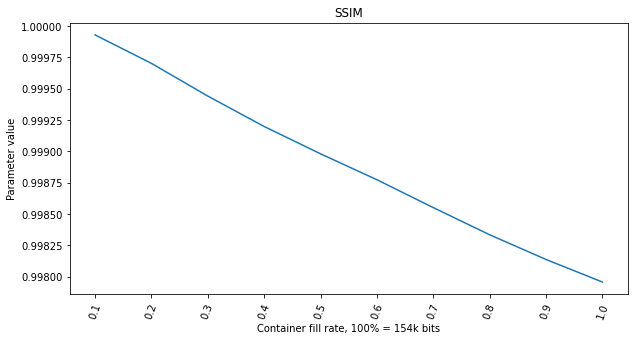

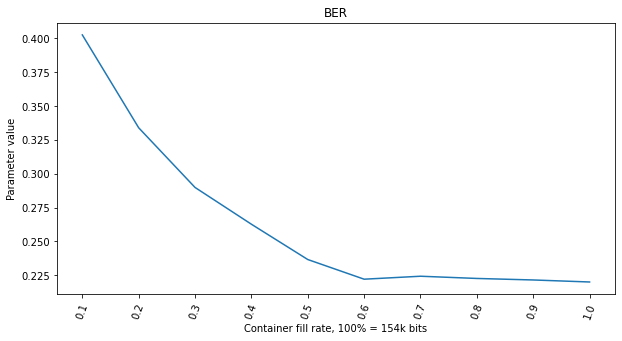

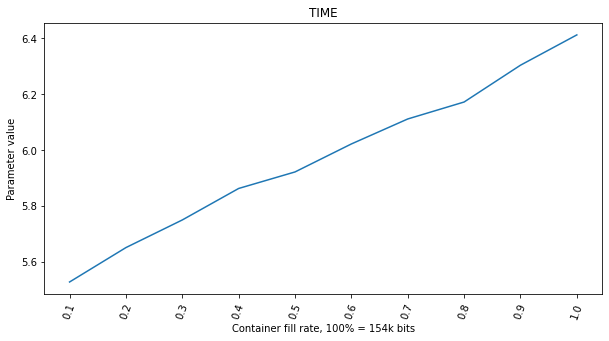

In [35]:
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

data = {'PSNR': p_v, 'SSIM': s_v, 'BER': b_v, 'TIME': t_v}

for d in data:
    plt.figure(figsize=(10, 5))
    custom_plot(x_vals, data[d])
    
    plt.xlabel('Container fill rate, 100% = 154k bits')
    plt.ylabel('Parameter value')
    plt.xticks(x_vals, rotation = 70)
    plt.title(d)
    
    plt.show()

In [36]:
def get_block_indexes_structure_from_route(route):
    i = 0
    res_coefs = dict()
    res_idxs = dict()
    b_ord = []
    for i in route[0]:
        if i not in b_ord:
            b_ord.append(i)
    
    for b in set(route[0]):
        res_coefs[b] = []
        res_idxs[b] = []
    
    for i in range(len(route[0])):
        res_coefs[route[0][i]].append(route[1][i])
        res_idxs[route[0][i]].append(i)
    
    return {'block_order': b_ord, 'coefs': res_coefs, 'indexes': res_idxs}


def get_mes_from_block(block, coefs):
    mes = []
    n = len(block)
    
    dct_block = dct2d(block)
    
    for i in coefs:
        row = i // n
        col = i % n
        
        c = floor(dct_block[row][col])
        
        if (c < 0 and c % 2 == 1) or (c > 0 and c % 2 == 0):
            mes.append(0)
        else:
            mes.append(1)
    
    return mes
        
        
def embed_mes_into_block(block, mes, coefs):
    dct_block = dct2d(block)
    n = len(block)
    
    for i in range(len(coefs)):
        c_ind = coefs[i]
        
        row = c_ind // n
        col = c_ind % n
        
        c_orig = dct_block[row][col]
        c = floor(c_orig)
        
        if mes[i] == 0:
            if (c < 0 and c % 2 == 1) or (c > 0 and c % 2 == 0):
                continue
        else:
            if (c < 0 and c % 2 == 0) or (c > 0 and c % 2 == 1):
                continue
                
        r = 0
        
        if abs(c) > 1:
            r = randint(0, 2)
        elif c == 1:
            r = 0
        else:
            r = 1
        
        if r == 1:
            dct_block[row][col] = c_orig - 1
        else:
            dct_block[row][col] = c_orig + 1
    
    return idct2d(dct_block)
        

def get_metrics_iterative_embedding(im, mes, threshold=10):
    U, emb = insert_message_PM1(im, mes)
    res = extract_message(emb, U)
    
    ssim_noise = ssim(im, emb, data_range=emb.max() - emb.min())
    ber = count_BER(mes, res)
    psnr = PSNR(im, emb)
    
    if ber != 0:
        block_dict = get_block_indexes_structure_from_route(U)
        blocks = cut_image_into_blocks(emb)
        n = len(blocks)
        
        for b_ind in block_dict['block_order']:
                
            indexes = block_dict['indexes'][b_ind]
            coefs = block_dict['coefs'][b_ind]
            
            part_of_message_to_embed = [mes[i] for i in indexes]
            
            row_b = b_ind // n
            col_b = b_ind % n
            
            b = blocks[row_b][col_b]
            b_temp = b
            ber = 1
            
            t = 0
            n_mes = []
            
            while ber != 0 and t <= threshold:
                b_temp = embed_mes_into_block(b_temp, part_of_message_to_embed, coefs)
                n_mes = get_mes_from_block(b_temp, coefs)
                
                ber_temp = count_BER(n_mes, part_of_message_to_embed)
                if ber_temp < ber:
                    b = b_temp
                
                ber = ber_temp
                t += 1

            blocks[row_b][col_b] = b
            
            n_mes = get_mes_from_block(blocks[row_b][col_b], coefs)
        
    emb = concatenate_image(blocks)
    res = extract_message(emb, U)
    
    ssim_noise = ssim(im, emb, data_range=emb.max() - emb.min())
    ber = count_BER(mes, res)
    psnr = PSNR(im, emb)   
    
    return psnr, ssim_noise, ber

In [37]:
get_metrics_iterative_embedding(test_image, message)

(45.71325072034974, 0.9501677457742274, 0.12406154326163686)

In [31]:
def experiment_with_iterative_embedding(files, threshold=10):
    MAX_VALUE = 153843
    PERCENTAGES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    PSNR_VALUES = []
    SSIM_VALUES = []
    BER_VALUES = []
    TIME_VALUES = []
    
    for p in PERCENTAGES:
        m_len = round(p * MAX_VALUE)
        m = randint(0, 2, size=int(m_len))
        
        print(len(m))
        
        p = []
        s = []
        b = []
        t = []
        for f in files:
            path_to_images = os.getcwd() + "/images/grey/"
            
            start = time.time()
            t_image = np.float32(np.asarray(cv2.imread(path_to_images + f, cv2.IMREAD_GRAYSCALE)))
            psnr, ssim_noise, ber = get_metrics_iterative_embedding(t_image, m)
            end = time.time()
            
            t.append(end-start)
            p.append(psnr)
            s.append(ssim_noise)
            b.append(ber)
        
        PSNR_VALUES.append(np.mean(p))
        SSIM_VALUES.append(np.mean(s))
        BER_VALUES.append(np.mean(b))
        TIME_VALUES.append(np.mean(t))
    
    return PSNR_VALUES, SSIM_VALUES, BER_VALUES, TIME_VALUES

In [38]:
p_v_e, s_v_e, b_v_e, t_v_e = experiment_with_iterative_embedding(onlyfiles)

15384
30769
46153
61537
76922
92306
107690
123074
138459
153843


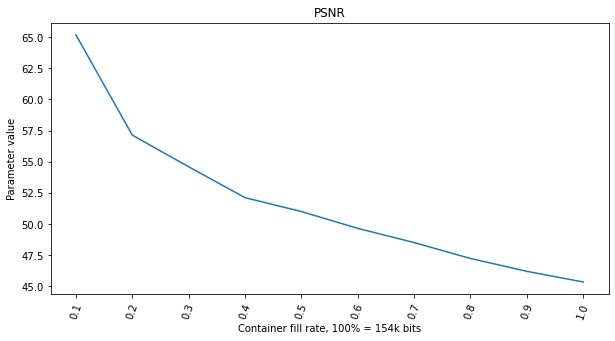

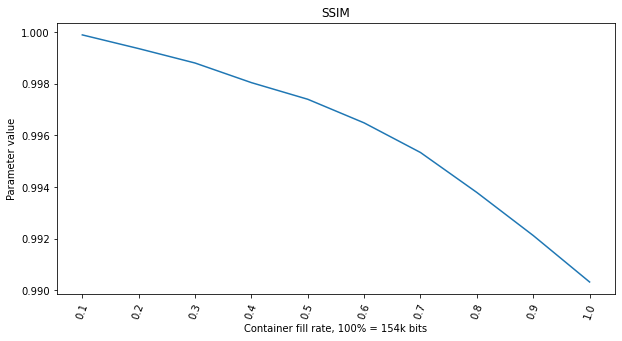

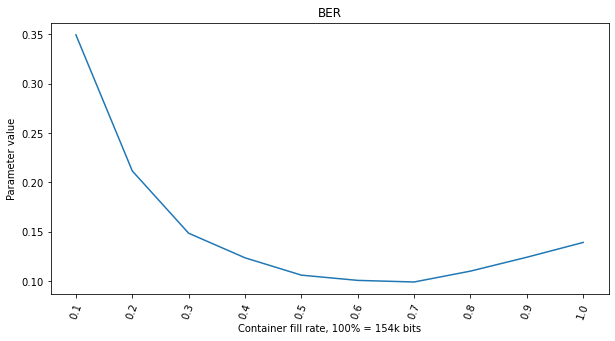

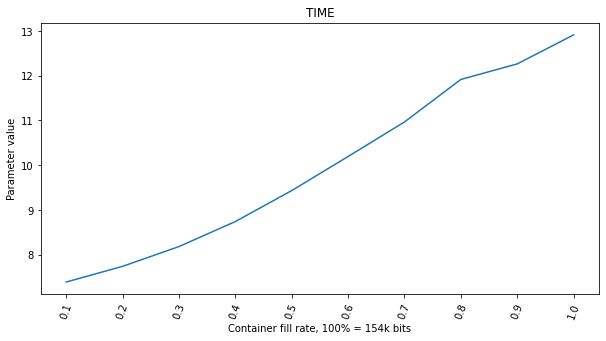

In [39]:
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

data = {'PSNR': p_v_e, 'SSIM': s_v_e, 'BER': b_v_e, 'TIME': t_v_e}

for d in data:
    plt.figure(figsize=(10, 5))
    custom_plot(x_vals, data[d])
    
    plt.xlabel('Container fill rate, 100% = 154k bits')
    plt.ylabel('Parameter value')
    plt.xticks(x_vals, rotation = 70)
    plt.title(d)
    
    plt.show()

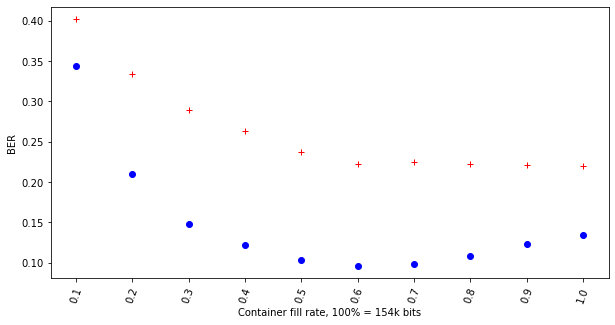

In [33]:
data = {'BER_DEFAULT': b_v, 'BER_ITER': b_v_e }
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

plt.figure(figsize=(10, 5))
plt.plot(x_vals, data['BER_DEFAULT'], 'r+', x_vals, data['BER_ITER'], 'bo')

plt.xlabel('Container fill rate, 100% = 154k bits')
plt.ylabel('BER')
plt.xticks(x_vals, rotation = 70)

plt.show()

In [32]:
embedded_image

array([[226., 227., 226., ..., 249., 251., 253.],
       [227., 225., 225., ..., 249., 250., 253.],
       [225., 227., 226., ..., 246., 248., 252.],
       ...,
       [183., 186., 184., ..., 189., 187., 190.],
       [182., 183., 184., ..., 187., 189., 186.],
       [182., 183., 183., ..., 187., 190., 188.]], dtype=float32)

In [33]:
block_dict = get_block_indexes_structure_from_route(U)

In [34]:
block_ind = 1
coefs = block_dict['coefs'][block_ind]
indexes = block_dict['indexes'][block_ind]

blocks = cut_image_into_blocks(embedded_image)
block = blocks[0][1]

mes_block = [message[i] for i in indexes]

print(mes_block)
print(len(coefs))
print(len(indexes))

[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0]
32
32
